In [14]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import pickle

In [15]:
def Gaussian_pdf(mu, sigma, stds=4):
    x = np.linspace(mu - stds*sigma, mu + stds*sigma, 100)
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return x, y

def truncated_Gaussian_moments(mu, var, a=0):
    """Compute the mean and variance of a truncated normal distribution."""
    sigma = np.sqrt(var)
    alpha = (a - mu) / sigma
    
    Z = 1 - norm.cdf(alpha)
    phi_alpha = norm.pdf(alpha)
    
    mu_t = mu + sigma * (phi_alpha / Z)
    var_t = var * (1 + (alpha * phi_alpha / Z) - (phi_alpha / Z) ** 2)
    
    return mu_t, var_t

def sigma_w_to_eta(sigma_w, V_th, tau_m, f):
    """Convert sigma_w to eta."""
    return (sigma_w * np.sqrt(tau_m)) / V_th

def compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc):
    """Compute the expected phase of firing."""
    A = 1 / np.sqrt(1 + (tau_m * omega)**2)
    T = (2 * np.pi) / omega
    varphi = -np.arctan(omega * tau_m) 
    numerator = R_m * I_s * (1 - np.exp(-T / tau_m)) - V_th
    denominator = R_m * I_osc * A * (1 - np.exp(-T / tau_m))
    phi_i = np.arccos(numerator / denominator) - varphi
    return phi_i

def compute_var_phi_fromPRC_1(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N):
    """Compute the variance in phase of firing."""
    T = 1 / f
    A = 1 / np.sqrt(1 + (tau_m * omega) ** 2)
    varphi = -np.arctan(omega * tau_m)
    phi_Is = compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc)
    alpha = I_s/I_s_ref
    numerator = alpha**2 * eta**2 * V_th**2 * (1 - np.exp(-2*T / tau_m))
    denominator = 2 * R_m**2 * I_osc**2 * A**2 * (1 - np.exp(-T / tau_m))**2 * np.sin(phi_Is + varphi)**2
    var_phi_Is = numerator / denominator
    return var_phi_Is

def compute_var_phi_fromPRC_2(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N):
    """Compute the variance in phase of firing."""
    T = 1 / f
    A = 1 / np.sqrt(1 + (tau_m * omega) ** 2)
    eff_osc_amp = R_m * I_osc * A * (1 - np.exp(-T / tau_m))  # effective oscillation amplitude
    eff_stim_current = R_m * I_s * (1 - np.exp(-T / tau_m))   # effective stimulus current
    alpha = I_s/I_s_ref
    numerator = alpha**2 * eta**2 * V_th**2 * (1 - np.exp(-2 * T / tau_m))
    denominator = 2 * (eff_osc_amp**2 - (V_th - eff_stim_current)**2)
    var_phi = numerator / denominator
    return var_phi

def compute_var_phi_fromdynamics(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N):
    """Compute the variance in phase of firing."""
    phi_Is = compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc)
    exp_term = np.exp(-2 / (f * tau_m))
    alpha = I_s/I_s_ref
    numerator = omega**2 * alpha**2 * eta**2 * V_th**2 * (1 - exp_term) * tau_m**2
    denominator = 2 * (-V_th + R_m * I_s - R_m * I_osc * np.cos(phi_Is))**2
    var_phi = numerator / denominator
    return var_phi

def get_distr(R_m, V_th, eta, tau_m, I_osc, f, M, range_frac, N):
    omega = 2 * np.pi * f
    I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac)
    Is_range = np.linspace(I_min, I_max, M)
    means = [compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc) for I_s in Is_range]
    variances = [compute_var_phi_fromdynamics(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N) for I_s in Is_range]
    return np.array(means), np.array(variances), Is_range

def get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=.9):
    A = 1 / np.sqrt(1 + (tau_m * omega)**2)
    T = (2 * np.pi) / omega
    expon = np.exp(-T / tau_m)
    frac_denom = (1 - expon) * R_m * I_osc * A
    
    I_min = (V_th / frac_denom - 1) * I_osc * A
    I_max = (V_th / frac_denom + 1) * I_osc * A
    
    corr_frac = (1 - range_frac) * (I_max - I_min) / 2
    I_min += corr_frac
    I_max -= corr_frac
    
    return I_min, I_max

In [18]:
# Example usage with provided parameters
R_m = 142 * 1e6  # 142 MΩ
V_th = 15 * 1e-3  # 15 mV
tau_m = 24 * 1e-3  # 24 ms
f = 5  # 5 Hz
omega = 2 * np.pi * f  # 5 Hz in rad/s
I_osc = 40 * 1e-12  # 40 pA
M = 5  # number of input levels
range_frac = 0.6  # fraction of range to use
sigma_w_avg = (0.012 + 0.015) / 2  # average sigma_w
eta = sigma_w_to_eta(sigma_w_avg, V_th, tau_m, f)  # Calculate eta

I_s_ref, _ = get_automatic_range(R_m, V_th, tau_m, 2*np.pi*1, I_osc, range_frac)

means, variances, Is_range = get_distr(R_m, V_th, eta, tau_m, I_osc, f, M, range_frac, N=1)
print("Means:", means)
print("Variances:", variances)

Means: [2.86034231 2.52153385 2.2168412  1.91214855 1.57334009]
Variances: [0.18480347 0.16043019 0.1765804  0.23081032 0.38486194]


In [19]:
fs_grid = [1, 5, 20, 50]
etas_grid = [0.05, 0.1, 0.2, 0.3]
#sigmas_w = eta_to_sigma_w(np.array(etas_grid), V_th, tau_m, f)
alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

plt.figure(figsize=(15,15), dpi=600)
count = 1
for i, eta in enumerate(etas_grid):
    for j, f in enumerate(fs_grid):
        means, variances, Is_range = get_distr(R_m, V_th, eta, tau_m, I_osc, f, M, range_frac, N=1)
        means, variances = truncated_Gaussian_moments(means, variances, a=0)
        
        plt.subplot(4,4,count)
        for k, Is in enumerate(Is_range):
            x, y = Gaussian_pdf(means[k], np.sqrt(variances[k]))
            plt.plot(x, y, linewidth=2, linestyle='-', color=c[k], label=str(int(Is*1e12))+" pA")
        
        plt.title(r"$\eta = $" + str(eta) + r", $f = $" + str(f))
        plt.legend(frameon=False, fontsize=8)
        plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=14)
        plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=14)
        #plt.xlim(-np.pi/2, (5/2)*np.pi)
        plt.xlim(0, 2*np.pi)
        plt.ylim(0, 4)
        plt.yticks(fontsize=14)
        sb.despine()
        count+=1
        
plt.tight_layout()

#plt.savefig('plots/phase_distr_theo.png', dpi=600)

plt.show()

In [20]:
def approx_mi(means, variances):
    return np.log(np.mean(variances) + np.var(means)) - np.mean(np.log(variances))

def numerical_mi(means, variances, n_samples=int(1e4)):
    samples = []
    for mean, var in zip(means, variances):
        samples.extend(norm.rvs(loc=mean, scale=np.sqrt(var), size=n_samples))
    histogram, _ = np.histogram(samples, bins='auto', density=True)
    histogram = histogram + np.finfo(float).eps
    H_Y = -np.sum(histogram * np.log(histogram) * np.diff(np.linspace(np.min(samples), np.max(samples), len(histogram) + 1)))

    H_Y_given_X = np.mean([0.5 * np.log(2 * np.pi * np.e * var) for var in variances])

    return H_Y - H_Y_given_X

def get_R(mis, fs, tau_s, corr=True, norm=True):
    info_rate = mis * fs[np.newaxis, :]
    
    if corr:
        corr_fact_sampling = (1 - np.exp(-(1/(fs*tau_s))))
        info_rate = info_rate * corr_fact_sampling[np.newaxis, :]
    
    if norm:
        info_rate_norm = np.zeros_like(info_rate)  
        for index, row in enumerate(info_rate):
            info_rate_norm[index, :] = row/np.max(row)
        info_rate = info_rate_norm
        
    return info_rate

In [21]:
M = 10
res = 200
fs = np.linspace(1, 50, res)
etas = np.linspace(0.001, 0.3, res)
mis_approx = np.zeros((res,res))
mis_numerical = np.zeros((res,res))
for i, eta in enumerate(etas):
    print(i)
    for j, f in enumerate(fs):
        means, variances, Is_range = get_distr(R_m, V_th, eta, tau_m, I_osc, f, M, range_frac, N=1)
        mis_approx[i, j] = approx_mi(means, variances)
        mis_numerical[i, j] = numerical_mi(means, variances, n_samples=int(1e4))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [56]:
tau_s = 100e-3
info_rate_approx_norm = get_R(mis_approx, fs, tau_s=tau_s, corr=True, norm=True)
info_rate_numerical_norm = get_R(mis_numerical, fs, tau_s=tau_s, corr=True, norm=True)

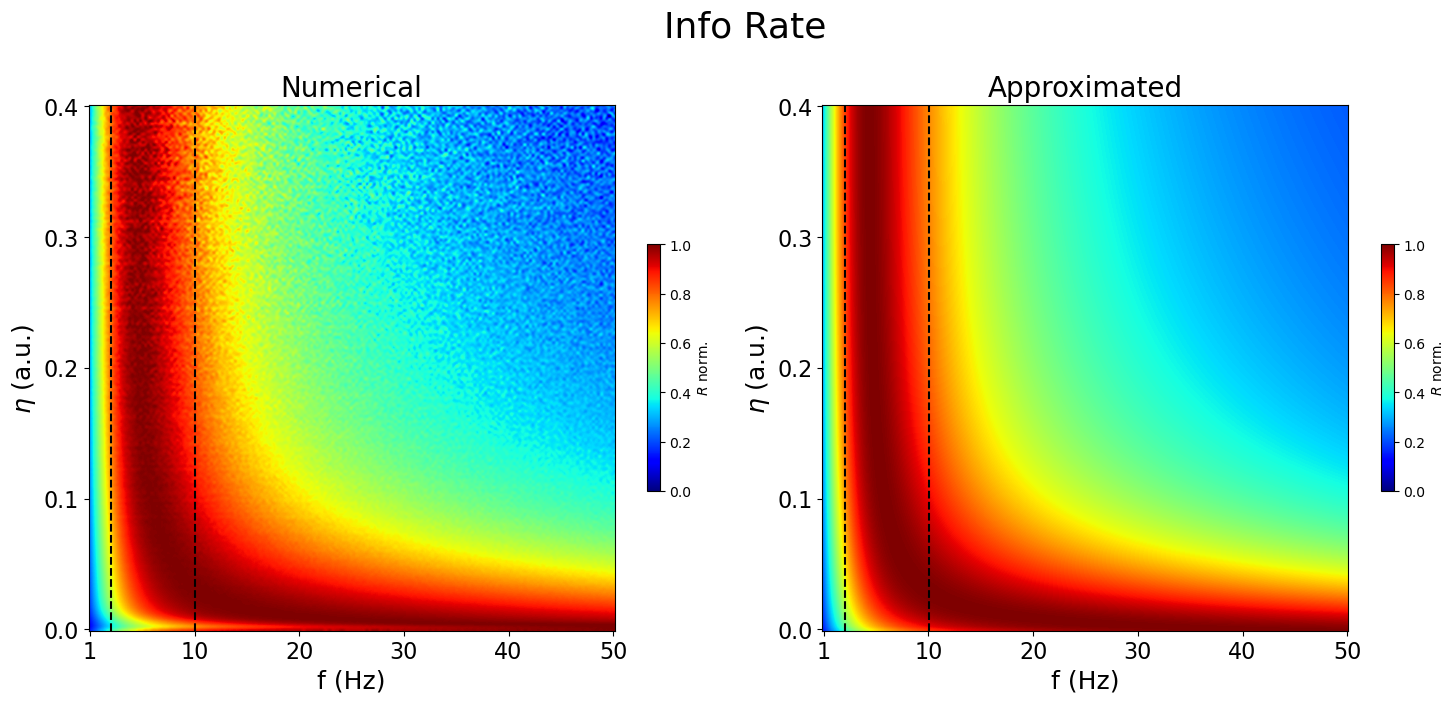

In [57]:
plt.figure(figsize=(15,7))

plt.suptitle("Info Rate", fontsize=26)

plt.subplot(121)
plt.title('Numerical', fontsize=20)
plt.imshow(info_rate_numerical_norm, origin='lower', cmap='jet', vmin=0, interpolation='lanczos')
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).astype(int), fontsize=16)
plt.yticks(np.linspace(0, res-1, 5), np.linspace(0.001, 0.4, 5).round(2), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='$R$ norm.', shrink=.4)
plt.axvline(2/50*res, c='k', linestyle='--')
plt.axvline(10/50*res, c='k', linestyle='--')


plt.subplot(122)
plt.title('Approximated', fontsize=20)
plt.imshow(info_rate_approx_norm, origin='lower', cmap='jet', vmin=0, interpolation='lanczos')
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 50, 6).astype(int), fontsize=16)
plt.yticks(np.linspace(0, res-1, 5), np.linspace(0.001, 0.4, 5).round(2), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='$R$ norm.', shrink=.4)
plt.axvline(2/50*res, c='k', linestyle='--')
plt.axvline(10/50*res, c='k', linestyle='--')


plt.tight_layout()
#plt.savefig('plots/info_rate_approx.png', dpi=600)
plt.show()

## Simulations

In [24]:
def simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, M, dt, t, n_neurons):
    #I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, omega)
    alpha = I_s/I_s_ref
    sigma_W = eta * alpha * V_th / np.sqrt(tau_m)
    phi_0 = compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc)
    
    V = np.zeros(n_neurons)
    first_spike_phase = np.empty(n_neurons, dtype='object')
    first_spike_phase[:] = None
    has_spiked = np.zeros(n_neurons, dtype=bool)
    for i in range(len(t)):
        xi = np.random.normal(0, 1/np.sqrt(dt), n_neurons)
        I_theta = I_osc * np.cos(omega * t[i] - np.pi + phi_0)
        dV_dt = (-V + R_m * I_theta + R_m * I_s + tau_m * sigma_W * xi) / tau_m
        V += dV_dt * dt
        #xi = np.random.normal(0, 1, n_neurons)
        #V += ((-V + R_m * I_theta + R_m * I_s) / tau_m) * dt + (sigma_W * xi) * np.sqrt(dt)
        
        spiked = V >= V_th
        if np.any(spiked):
            V[spiked] = 0 
            if (omega * t[i] - np.pi + phi_0) > np.pi:
                mask = spiked & (first_spike_phase == None)
                first_spike_phase[mask] = (omega * t[i] + phi_0) % (2*np.pi)

                if np.all(first_spike_phase != None):
                    break
                
    return first_spike_phase

In [25]:
def get_distr_empirical(R_m, V_th, eta, tau_m, I_osc, f, M, dt, t, num_trials, range_frac):
    omega = 2*np.pi*f
    I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=range_frac)
    Is_range = np.linspace(I_min, I_max, M)
    
    means = []
    variances = []
    all_first_spike_phases = []
    for I_s in Is_range:
        first_spike_phases = simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, M, dt, t, num_trials)
        first_spike_phases = np.where(first_spike_phases == None, np.nan, first_spike_phases)
        all_first_spike_phases.append(first_spike_phases)  
        means.append( np.nanmean(first_spike_phases) )
        variances.append( np.nanvar(first_spike_phases) )
        
    return np.array(means), np.array(variances), all_first_spike_phases, Is_range

In [26]:
# Params
f = 15.                 # Hz
eta = 0.05 #0.11             # a.u.
M = 5                  # number input levels

# Simulation parameters
dt = 1e-4              # Time step for numerical integration
t_end = 2 / f          # Duration of one cycle
t = np.arange(0, t_end, dt)
num_trials = 5000      # Number of trials

In [27]:
means, variances, all_phis, Is_range = get_distr_empirical(R_m, V_th, eta, tau_m, I_osc, f, M, dt, t, num_trials, range_frac)

C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\lib\histograms.py:400: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\lib\histograms.py:401: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


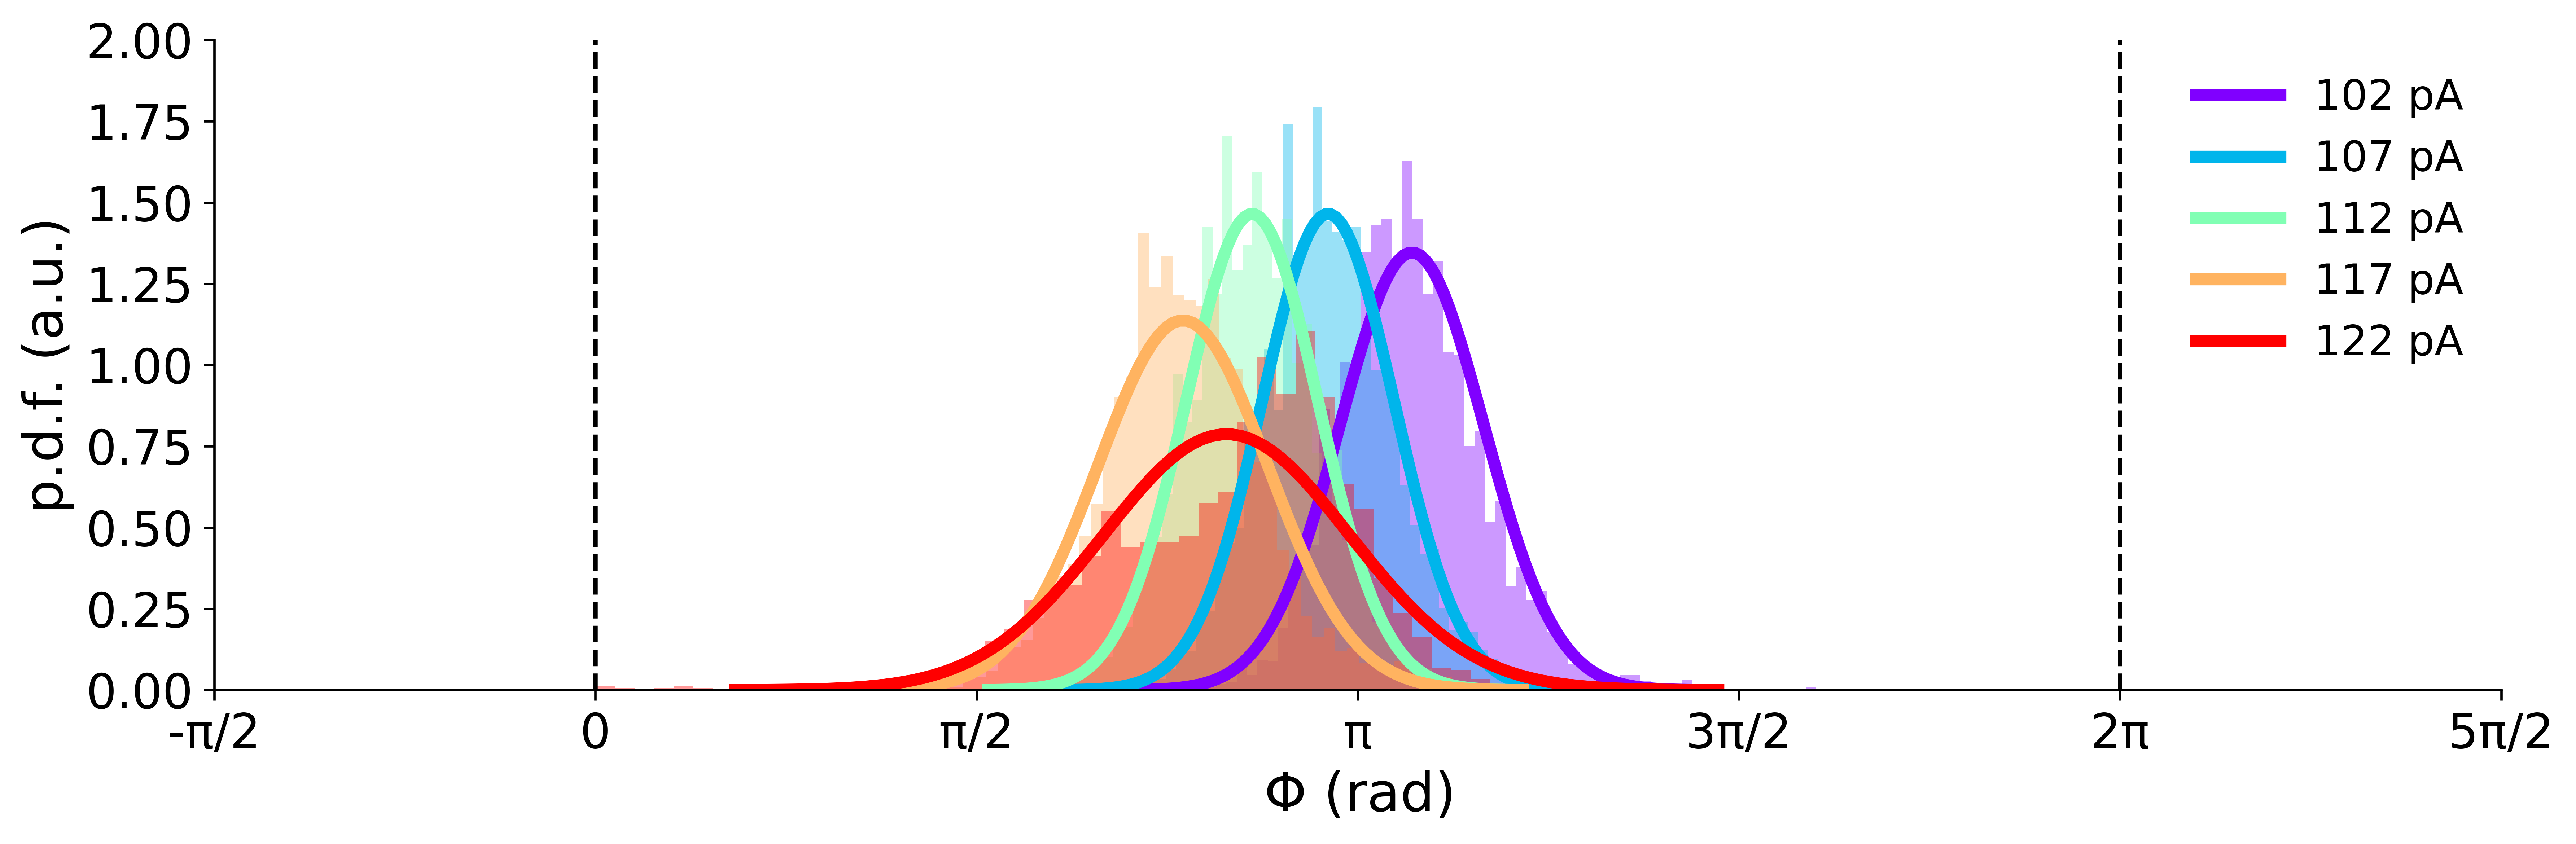

In [28]:
plt.figure(figsize=(12,4), dpi=600)

alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='-', color=c[i], label=str(int(Is*1e12))+" pA")
    plt.hist(all_phis[i], bins='auto', density=True, color=c[i], alpha=.4)

plt.legend(frameon=False, fontsize=14)
plt.ylabel('p.d.f. (a.u.)', fontsize=18)
plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=18)
plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=16)
plt.xlim(-np.pi/2, (5/2)*np.pi)
plt.ylim(0, 2)
plt.yticks(fontsize=16)

plt.axvline(0, linestyle='--', color='k')
plt.axvline(2*np.pi, linestyle='--', color='k')

sb.despine()
plt.tight_layout()
plt.show()

In [58]:
fs_grid = [1, 5, 20, 50]
etas_grid = [0.05, 0.1, 0.2, 0.3]
alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

plt.figure(figsize=(15,15), dpi=600)
count = 1
for i, eta in enumerate(etas_grid):
    for j, f in enumerate(fs_grid):
        t_end = 2 / f
        t = np.arange(0, t_end, dt)
        
        means, variances, all_phis, Is_range = get_distr_empirical(R_m, V_th, eta, tau_m, I_osc, f, M, dt, t, num_trials, range_frac)
        
        plt.subplot(4,4,count)
        for k, Is in enumerate(Is_range):
            x, y = Gaussian_pdf(means[k], np.sqrt(variances[k]))
            plt.plot(x, y, linewidth=2, linestyle='-', color=c[k], label=str(int(Is*1e12))+" pA")
            plt.hist(all_phis[k], bins='auto', density=True, color=c[k], alpha=.4)
        
        plt.title(r"$\eta = $" + str(eta) + r", $f = $" + str(f))
        plt.legend(frameon=False, fontsize=8)
        plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=14)
        plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=14)
        #plt.xlim(-np.pi/2, (5/2)*np.pi)
        plt.xlim(0, 2*np.pi)
        plt.ylim(0, 4)
        plt.yticks(fontsize=14)
        sb.despine()
        count+=1
plt.tight_layout()

#plt.savefig('plots/phase_distr_sim.png', dpi=600)

plt.show()

### This happens because fixing I_osc and increasing freq leads to higher I_s, dominating over I_osc. Alternative approaches are: fixing v_osc_amp, or adjusting I_osc so that I_s range is constant. At the same time, changes in I_s and I_osc should add proportionally to the noise.

### Low-pass filtering properties of membrane justifies using a fixed I_osc. And then we can also test adjusted I_osc to equate v_osc_amp across freq range for the "ideal world".

### At low frequencies (1-5 Hz) the difference between I_s levels is big enough so that voltage reset due to previous-cycle spikes do not interfere with phase relationships. However, at intermediate frequencies (10-20 Hz), we still have some previous-cycle spikes but with lower difference between I_s, and therefore, the previous-cycle spike reset induces important delays in phase, making the Gaussians overlap. Therefore, what we see if previous-cycle spike interference.

### Moreover, we see reduction of variance in strong inputs due to hard phase cutoff at 0. Further, these a shift to earlier phases with increased noise, which enhances the cutoff effect.

## Membrane oscillations

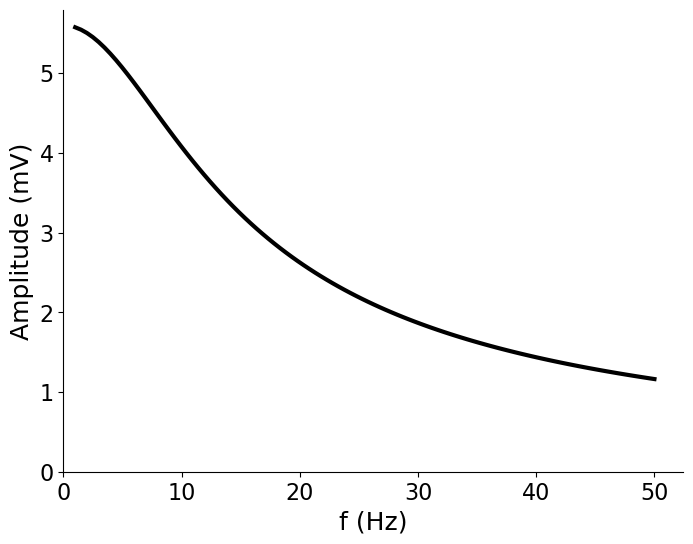

In [44]:
def amplitude_mem_potential(R_m, I_osc, tau_m, f):
    A = 1 / np.sqrt(1 + (tau_m * 2 * np.pi * f)**2)
    amplitude = R_m * I_osc * A
    return amplitude

fs = np.linspace(1,50,100)
I_osc_ = 140 * 1e-12  # 40 pA
amp = amplitude_mem_potential(R_m, I_osc_, tau_m, fs)

plt.figure(figsize=(8,6))

plt.plot(fs, amp*1e3, color='k', linewidth=3)

#plt.hlines(y=1/np.sqrt(2), xmin=0, xmax=cutoff_frequency(tau_m), linestyle='--', color='r', linewidth=1)

plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('Amplitude (mV)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0)
plt.xlim(0)

sb.despine()
#plt.savefig('amp.png', dpi=600)
plt.show()